In [1]:
# Set up the environment
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
%matplotlib inline

In [2]:
# Upload the data
X_train = pd.read_csv('data/processed/X9_train.csv', index_col=0)
y_train = pd.read_csv('data/processed/y9_train.csv', index_col=0)
X_test = pd.read_csv('data/processed/X9_test.csv', index_col=0)
y_test = pd.read_csv('data/processed/y9_test.csv', index_col=0)

In [3]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21477 entries, 7 to 9996
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   NUMBRANCH          21477 non-null  float64
 1   UGDS               21477 non-null  float64
 2   TUITFTE            21477 non-null  float64
 3   INEXPFTE           21477 non-null  float64
 4   PFTFAC             21477 non-null  float64
 5   UG25abv            21477 non-null  float64
 6   COMP_ORIG_YR4_RT   21477 non-null  float64
 7   WDRAW_ORIG_YR4_RT  21477 non-null  float64
 8   ENRL_ORIG_YR4_RT   21477 non-null  float64
 9   DEBT_MDN           21477 non-null  float64
 10  Year               21477 non-null  float64
 11  Cost               21477 non-null  float64
 12  Complete           21477 non-null  float64
 13  RetentionFT        21477 non-null  float64
 14  PREDDEG_1          21477 non-null  float64
 15  PREDDEG_2          21477 non-null  float64
 16  PREDDEG_3          2147

In [4]:
X_train.drop('Year', axis=1, inplace=True)
X_test.drop('Year', axis=1, inplace=True)

In [5]:
y_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21477 entries, 47938 to 57928
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   CURROPER  21477 non-null  bool 
dtypes: bool(1)
memory usage: 188.8 KB


In [6]:
y = y_train.CURROPER.ravel()

# Modeling
## Logistic Regression

Hyperparameters to tune:
- C = inverse of regularization strength; smaller values are stronger regularization, may lead to underfit model; large C may lead to overfitting 
- l1_ratio = 0 == L2 penalty; 1 == L1 penalty

In [7]:
# Import and instantiate model
from sklearn.linear_model import LogisticRegression

In [8]:
# Hyperparameter search
from sklearn.model_selection import RandomizedSearchCV

c_grid = [0.001, 0.01, 0.1, 1, 10]
l1_ratio_grid = [0, 0.1, 0.25, 0.5, 0.75, 0.9, 1]
max_iter_grid = [100, 500, 1000, 1500, 2000]

lr_grid = {'C':c_grid, 'l1_ratio':l1_ratio_grid,'max_iter':max_iter_grid}

In [9]:
logreg = LogisticRegression(solver = 'saga', penalty = 'elasticnet')
logreg_cv = RandomizedSearchCV(logreg, lr_grid, cv=5)

In [10]:
start= time.time()
logreg_cv.fit(X_train, y)
end = time.time()
print('GridSearch Time:', end-start)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


GridSearch Time: 45.73082900047302


In [11]:
print("Best params: " , logreg_cv.best_params_)
print("Best score: ", logreg_cv.best_score_)

Best params:  {'max_iter': 1000, 'l1_ratio': 1, 'C': 0.001}
Best score:  0.9100898689091078


### Grid Results
- Original run: l1_ratio=0.9, max_iter=500, C=0.1
- Second run: l1_ratio=0.75, max_iter=1000, C=0.001
- Third run: l1_ratio = 1, max_iter = 1000, C=0.01

### Run the model with the best parameters

In [12]:
modelLR = LogisticRegression(C = 0.01, penalty = 'elasticnet', l1_ratio=1, max_iter = 1000, solver = 'saga')
start = time.time()
modelLR.fit(X_train, y)
end = time.time()
print("Fit time = ", end - start)

start = time.time()
lr_pred = modelLR.predict(X_test)
end = time.time()
print("Predict time = ", end - start)

lr_pred_prob = modelLR.predict_proba(X_test)[:, 1]

Fit time =  0.8181087970733643
Predict time =  0.0013539791107177734


### Evaluate the model

In [13]:
# Confusion matrix
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, lr_pred))

[[   0  828]
 [   0 8377]]


In [14]:
# Classification report
print(classification_report(y_test, lr_pred))

              precision    recall  f1-score   support

       False       0.00      0.00      0.00       828
        True       0.91      1.00      0.95      8377

    accuracy                           0.91      9205
   macro avg       0.46      0.50      0.48      9205
weighted avg       0.83      0.91      0.87      9205



/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


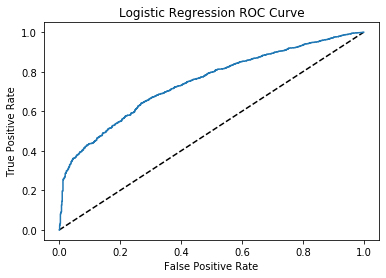

In [15]:
# ROC curve
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(y_test, lr_pred_prob)

plt.plot( [0,1], [0,1], 'k--')
plt.plot(fpr, tpr, label='Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.show()

In [16]:
print("AUC: ", roc_auc_score(y_test, lr_pred_prob))

AUC:  0.7452261021810926


### Model evaluation

Given the unbalanced classes, this model has good precision and recall for the majority class, and terrible precision and recall for the minority class.

One benefit of this model is that the coefficients are relatively easy to identify and understand.

In [17]:
# Coefficients
coeffic = modelLR.coef_
coeffic = coeffic[0]
labels = [i for i in X_train.columns]
numLab = len(labels)

In [18]:
coeffic = pd.DataFrame(coeffic, index=labels)
coeffic.columns= ['Coefficient']
coeffic.sort_values(by='Coefficient', inplace=True, ascending=False)
coeffic.head()

,Coefficient
ENRL_ORIG_YR4_RT,0.277681
UGDS,0.231456
PREDDEG_3,0.222966
PREDDEG_2,0.177932
NUMBRANCH,0.082136


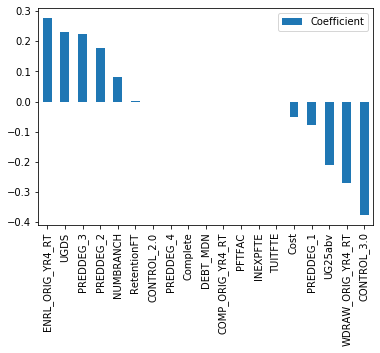

In [19]:
coeffic.plot.bar(y='Coefficient')
#plt.xticks(range(0, numLab), labels, rotation='vertical')
plt.show()

### Coefficient comments
- PREDDEG3 = Schools that offer predominantly bachelor's degrees. I think this was the largest group of schools, so it may just be a data balance size issue. (1= Certificate, 2 = Associated, 4 = Graduate)
- Enrollment (UGDS) seems to be the most important predictor (in some models), but it's worth checking how many values were imputed.
- Negative coefficient values
-- Control3 = Private for profit school
-- Control2 = Private nonprofit
--(So does this mean that public schools have no effect, or positive coeff value?)
- Withdraw
- UG25abv 

## Decision Tree Model

In [20]:
from sklearn.tree import DecisionTreeClassifier

In [21]:
criterion_grid = ['gini', 'entropy']
max_depth_grid = ['None', 3, 5, 10, 20, 30]
min_sample_split_grid = [2, 5, 10, 25, 50, 75, 100]
min_samples_leaf_grid = [2, 5, 10, 25, 50]
feature_grid = ["auto", "log2", 4, 5, 10, 12, 15, 20]

dtc_grid = {'criterion': criterion_grid, 
              'max_depth':max_depth_grid,
              'min_samples_split':min_sample_split_grid,
              'min_samples_leaf':min_samples_leaf_grid,
              'max_features':feature_grid }

In [22]:
tree = DecisionTreeClassifier()
tree_cv = RandomizedSearchCV(tree, dtc_grid, cv=5)
tree_cv.fit(X_train, y)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_features must be in (0, n_features]

  FitFailedWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    presort='deprecated',
                                                    random_state=None,
          

In [23]:
print("Best params: " , tree_cv.best_params_)
print("Best score: ", tree_cv.best_score_)

Best params:  {'min_samples_split': 50, 'min_samples_leaf': 5, 'max_features': 10, 'max_depth': 10, 'criterion': 'entropy'}
Best score:  0.9116263226695975


### Grid Search Results
- First run: sample_split=2; samples_leaf=2; max_features=4, max_depth=3, criterion=entropy
- Second run: sample_split=25, samples_leaf=25; max_features=12, max_depth=5, criterion='gini'
- Another run: min_sample_split=100; min_samples_leaf=25; max_features=15; max_depth=50; criterion = entropy

### Explore just the criterion and max_depth features, leaving the other arguments as the default. Plot the accuracy of different tree depths using both criterion measures.
Code modified from https://towardsdatascience.com/decision-tree-build-prune-and-visualize-it-using-python-12ceee9af752

In [24]:
from sklearn import metrics
max_depth = []
acc_gini = []
acc_entropy = []
for i in range(1, 31):
    gtree = DecisionTreeClassifier(criterion='gini', max_depth=i)
    gtree.fit(X_train, y)
    gpredict = gtree.predict(X_test)
    acc_gini.append(metrics.accuracy_score(y_test, gpredict))
    ##
    etree = DecisionTreeClassifier(criterion='entropy', max_depth=i)
    etree.fit(X_train, y_train)
    epredict = etree.predict(X_test)
    acc_entropy.append(metrics.accuracy_score(y_test, epredict))
    ##
    max_depth.append(i)

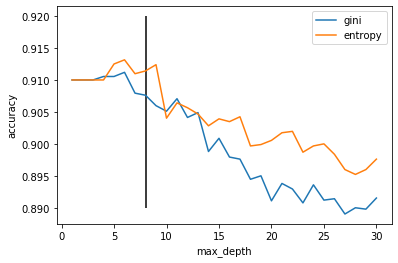

In [25]:
trees = pd.DataFrame({'acc_gini':pd.Series(acc_gini),
                     'acc_entropy':pd.Series(acc_entropy),
                     'max_depth':pd.Series(max_depth)})

plt.plot('max_depth', 'acc_gini', data=trees, label='gini')
plt.plot('max_depth', 'acc_entropy', data=trees, label='entropy')
plt.vlines(8, 0.89, 0.920)
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [26]:
# Train the decision tree using the identified hyperparameters
modelDT = DecisionTreeClassifier(criterion='gini', max_depth=8)
modelDT.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=8, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

/opt/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


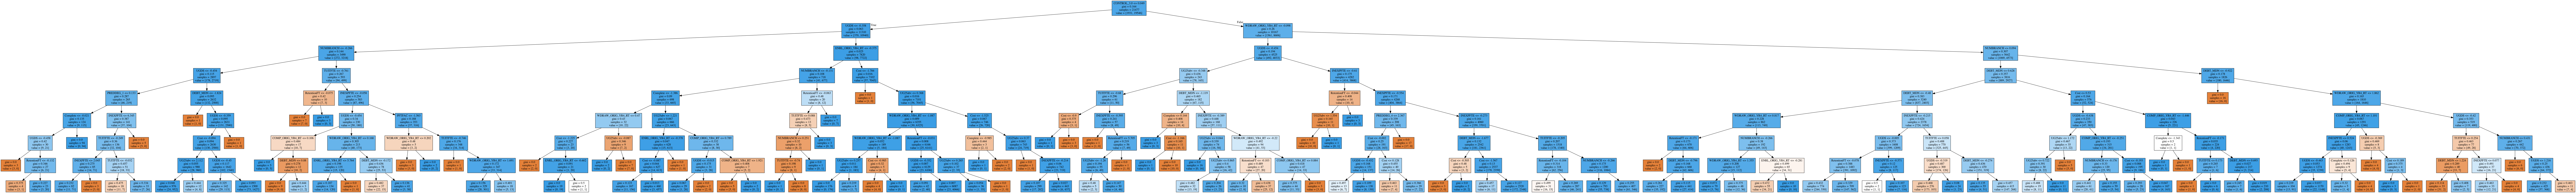

In [27]:
#from sklearn.tree import plot_tree
#plot_tree(modelDT)
# Code from https://towardsdatascience.com/decision-tree-build-prune-and-visualize-it-using-python-12ceee9af752

from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO
from IPython.display import Image
import pydotplus

dot_data = StringIO()
export_graphviz(modelDT, out_file=dot_data, filled=True, feature_names=X_train.columns)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png('tree.png')
Image(graph.create_png())

[Text(147.82661483253588, 205.35999999999999, 'X[18] <= 0.049\ngini = 0.164\nsamples = 21477\nvalue = [1931, 19546]'),
 Text(68.08133971291866, 181.2, 'X[1] <= -0.358\ngini = 0.063\nsamples = 11310\nvalue = [370, 10940]'),
 Text(30.73672248803828, 157.04, 'X[0] <= -0.266\ngini = 0.144\nsamples = 3490\nvalue = [272, 3218]'),
 Text(18.822488038277513, 132.88, 'X[1] <= -0.454\ngini = 0.115\nsamples = 2897\nvalue = [178, 2719]'),
 Text(10.41244019138756, 108.72, 'X[13] <= 0.133\ngini = 0.287\nsamples = 265\nvalue = [46, 219]'),
 Text(4.8057416267942585, 84.56, 'X[11] <= -0.021\ngini = 0.135\nsamples = 124\nvalue = [9, 115]'),
 Text(3.2038277511961724, 60.400000000000006, 'X[1] <= -0.458\ngini = 0.42\nsamples = 30\nvalue = [9, 21]'),
 Text(1.6019138755980862, 36.24000000000001, 'gini = 0.0\nsamples = 3\nvalue = [3, 0]'),
 Text(4.8057416267942585, 36.24000000000001, 'X[12] <= -0.132\ngini = 0.346\nsamples = 27\nvalue = [6, 21]'),
 Text(3.2038277511961724, 12.079999999999984, 'gini = 0.375\ns

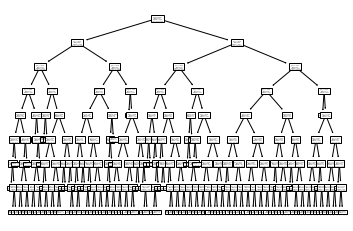

In [28]:
from sklearn.tree import plot_tree
plot_tree(modelDT)

In [29]:
# Use the trained tree to predict the testing data
dt_pred = modelDT.predict(X_test)
dt_pred_prob = modelDT.predict(X_test)

In [30]:
# Run this block for model evaluation 
#from sklearn import metrics
print("Model Metrics")
print("Accuracy:", metrics.accuracy_score(y_test, dt_pred))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_test, dt_pred))
print('Precision score for "Yes"' , metrics.precision_score(y_test, dt_pred, pos_label = 1))
print('Recall score for "No"' , metrics.recall_score(y_test, dt_pred, pos_label = 0))


Model Metrics
Accuracy: 0.9078761542639869
Balanced accuracy: 0.5744469270875684
Precision score for "Yes" 0.9226451105871786
Recall score for "No" 0.1678743961352657


In [31]:
print(confusion_matrix(y_test, dt_pred))

[[ 139  689]
 [ 159 8218]]


In [32]:
print(classification_report(y_test, dt_pred))

              precision    recall  f1-score   support

       False       0.47      0.17      0.25       828
        True       0.92      0.98      0.95      8377

    accuracy                           0.91      9205
   macro avg       0.69      0.57      0.60      9205
weighted avg       0.88      0.91      0.89      9205



## Random Forest Classifier

Hyperparameters:
- number of features per tree
- number of trees per forest (n_estimators)
- depth(?)

In [33]:
from sklearn.ensemble import RandomForestClassifier

In [34]:
n_tree_grid = [10,50,100,200,250,500]
crit_grid = ['gini', 'entropy']
max_depth_grid = ['None', 3, 5, 10, 15, 20]
min_sample_split_grid = [2, 5, 10, 20]
min_samples_leaf_grid = [2, 5, 10, 25, 50]
feature_grid = ["auto", "log2", 4, 5, 10, 12, 15, 19]

rfc_grid = {'n_estimators':n_tree_grid,
              'criterion': crit_grid, 
              'max_depth':max_depth_grid,
              'min_samples_split':min_sample_split_grid,
              'min_samples_leaf':min_samples_leaf_grid,
              'max_features':feature_grid }

In [35]:
forest = RandomForestClassifier()
start = time.time()
forest_cv = RandomizedSearchCV(forest, rfc_grid, cv=5)
forest_cv.fit(X_train, y)
end = time.time()
print("GridSearch time: ", end-start)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<=' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<=' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: '<=' not supported between instances of 'str' and 'int'

  FitFailedWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536

GridSearch time:  247.53922986984253


In [36]:
print("Best params: " , forest_cv.best_params_)
print("Best score: ", forest_cv.best_score_)

Best params:  {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 12, 'max_depth': 20, 'criterion': 'gini'}
Best score:  0.9264329381312557


### Grid Search Results
- First run: n_estimators=500; sample_split=20; samples_leaf=2, max_features='log2'; max_depth=20; criterion='entropy'
- Second run: n_estimators=50; sample_split=10; samples_leaf=10; max_features=auto; max_depth=20; criterion='entropy'
- Another run: n_estimators=100, split=20, leaf=2, features=5, depth=20, crit=entropy

In [37]:
# Choose default for split, leaf; use 'auto' for max features, which will default to sqrt(n_feature), 
# max_depth is half of depth of single tree (above)
modelRF = RandomForestClassifier(n_estimators = 100, max_features='auto',
                                max_depth=8, criterion='entropy')
modelRF.fit(X_train, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [38]:
rf_pred = modelRF.predict(X_test)
rf_pred_prob = modelRF.predict_proba(X_test)

In [39]:
print("Random Forest Classifier model")
print("Accuracy:", metrics.accuracy_score(y_test, rf_pred))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_test, rf_pred))
print('Precision score for Yes' , metrics.precision_score(y_test, rf_pred, pos_label = 1))
print('Recall score for No' , metrics.recall_score(y_test, rf_pred, pos_label = 0))

Random Forest Classifier model
Accuracy: 0.912221618685497
Balanced accuracy: 0.5120772946859904
Precision score for Yes 0.9120304844855743
Recall score for No 0.024154589371980676


In [40]:
print(confusion_matrix(y_test, rf_pred))

[[  20  808]
 [   0 8377]]


In [41]:
print(classification_report(y_test, rf_pred))

              precision    recall  f1-score   support

       False       1.00      0.02      0.05       828
        True       0.91      1.00      0.95      8377

    accuracy                           0.91      9205
   macro avg       0.96      0.51      0.50      9205
weighted avg       0.92      0.91      0.87      9205



## Best model
Which model has the best classification?

Given the unbalanced classes, it is not surprising that the logistic regression model has relatively poor performance on the minority class. Balancing the data (via resampling) might help improve this model. The benefit of this model is that the coefficients are relatively easy to interpret.

The decision tree model is relatively easy to interpret, and it is easy to determine the optimal depth. The recall and precision for the positive class are fairly good, but the precision and recall are not great for the negative class.

The random forest model is less easy to interpret, and it is more difficult to determine the optimal depth, since accuracy continues to improve as depth increases - which could lead to overfitting. The precision and recall for the positive class is fairly good, and the precision for the negative class much better than the decision tree for a very deep tree (deeper than the single decision tree model).


Random forest
- True precision = 93, True recall 1 (8353/8377)
- False precision = 89, False recall = .24 (627/828)
- [[ 201  627]
-  [  24 8353]]

Decision Tree
- True precision = 92, True recall = 98 (8242/8377)
- False precision = 54; False recall = 19 (669/828)
- [[ 159  669]
-  [ 135 8242]]

Logistic Regression
- [[   1  827]
-  [   2 8375]]

## Exploration of misclassified schools

In [42]:
# False positive (Predict open, but actually closed)

# False negative  (Predict closed, but actually open)
print(y_test.shape)
print(rf_pred.shape)

(9205, 1)
(9205,)


In [53]:
y_test['Predicted'] = rf_pred
y_test.head()

,CURROPER,Predicted
69259,True,True
51709,True,True
77410,True,True
72997,True,True
60179,True,True


In [56]:
y_test.reset_index(inplace=True)
y_test.head()

,index,CURROPER,Predicted
0,69259,True,True
1,51709,True,True
2,77410,True,True
3,72997,True,True
4,60179,True,True


In [57]:
X_test.reset_index(inplace=True)
X_test.head()

,index,NUMBRANCH,UGDS,TUITFTE,INEXPFTE,PFTFAC,UG25abv,COMP_ORIG_YR4_RT,WDRAW_ORIG_YR4_RT,ENRL_ORIG_YR4_RT,DEBT_MDN,Cost,Complete,RetentionFT,PREDDEG_1,PREDDEG_2,PREDDEG_3,PREDDEG_4,CONTROL_2.0,CONTROL_3.0
0,21325,-0.288916,-0.439628,0.371961,-0.277527,0.477174,0.285387,0.794630,-0.168719,-0.651332,-0.779762,-0.088695,0.937140,-0.057182,1.141462,-0.489159,-0.613036,-0.202535,-0.583698,1.050625
1,3778,-0.288916,-0.388565,-0.749941,-0.160667,1.128852,0.759404,-1.340148,-1.095300,-0.651332,-0.924632,-0.859428,0.604522,-0.058714,1.141462,-0.489159,-0.613036,-0.202535,-0.583698,-0.951815
2,29475,-0.243905,-0.398291,-0.009473,-0.419590,-1.536747,-0.070782,1.353523,-0.576376,-0.651332,-0.223934,0.452096,1.157635,-0.064843,1.141462,-0.489159,-0.613036,-0.202535,-0.583698,1.050625
3,25063,-0.288916,-0.454420,-0.442431,0.099911,-0.315832,-0.891768,-0.335942,0.270481,-0.651332,-0.311521,0.007057,-0.367907,-0.067420,-0.876070,2.044326,-0.613036,-0.202535,1.713214,-0.951815
4,12246,-0.198894,-0.430915,0.062236,-0.345056,-1.775863,1.223344,1.561995,-0.180313,-0.651332,0.301589,1.003308,0.679548,-0.057182,1.141462,-0.489159,-0.613036,-0.202535,-0.583698,1.050625


## Generate graphs for the report

In [58]:
predicted = pd.concat([X_test, y_test], axis=1)
predicted.head()

,index,NUMBRANCH,UGDS,TUITFTE,INEXPFTE,PFTFAC,UG25abv,COMP_ORIG_YR4_RT,WDRAW_ORIG_YR4_RT,ENRL_ORIG_YR4_RT,...,RetentionFT,PREDDEG_1,PREDDEG_2,PREDDEG_3,PREDDEG_4,CONTROL_2.0,CONTROL_3.0,index,CURROPER,Predicted
0,21325,-0.288916,-0.439628,0.371961,-0.277527,0.477174,0.285387,0.794630,-0.168719,-0.651332,...,-0.057182,1.141462,-0.489159,-0.613036,-0.202535,-0.583698,1.050625,69259,True,True
1,3778,-0.288916,-0.388565,-0.749941,-0.160667,1.128852,0.759404,-1.340148,-1.095300,-0.651332,...,-0.058714,1.141462,-0.489159,-0.613036,-0.202535,-0.583698,-0.951815,51709,True,True
2,29475,-0.243905,-0.398291,-0.009473,-0.419590,-1.536747,-0.070782,1.353523,-0.576376,-0.651332,...,-0.064843,1.141462,-0.489159,-0.613036,-0.202535,-0.583698,1.050625,77410,True,True
3,25063,-0.288916,-0.454420,-0.442431,0.099911,-0.315832,-0.891768,-0.335942,0.270481,-0.651332,...,-0.067420,-0.876070,2.044326,-0.613036,-0.202535,1.713214,-0.951815,72997,True,True
4,12246,-0.198894,-0.430915,0.062236,-0.345056,-1.775863,1.223344,1.561995,-0.180313,-0.651332,...,-0.057182,1.141462,-0.489159,-0.613036,-0.202535,-0.583698,1.050625,60179,True,True


In [59]:
false_pos = predicted.loc[(predicted.Predicted == True) & (predicted.CURROPER == False)]
false_pos.shape

(808, 23)

In [60]:
false_neg = predicted.loc[(predicted.Predicted==False) & (predicted.CURROPER==True)]
false_neg.shape

(0, 23)